## Extract one OC with the DBSCAN parameters

In [1]:
using PyCall
using Statistics , StatsBase
using  DataFrames, Printf

import PyPlot
sns= pyimport("seaborn")

## directory
rootdir = ENV["GAIA_ROOT"]
wdir    = "$rootdir/products"
votdir  = "$rootdir/products/votable"
plotdir = "$rootdir/products/testfull2"

push!(LOAD_PATH,"$rootdir/master/src")
using GaiaClustering


cd(wdir)

In [2]:
function _get_OC(df , dfcart, labels , labelmax)
    ra= df.raw[1, labels[labelmax]]
    dec= df.raw[2,labels[labelmax]]
    l= df.data[1, labels[labelmax]]
    b= df.data[2,labels[labelmax]]
    d= df.data[3,labels[labelmax]]
    pmra= df.raw[6, labels[labelmax]]
    pmdec= df.raw[7, labels[labelmax]]
    X= dfcart.data[1, labels[labelmax]]
    Y= dfcart.data[2, labels[labelmax]]
    Z= dfcart.data[3, labels[labelmax]]
    vl= df.data[4,labels[labelmax]]
    vb= df.data[5,labels[labelmax]]
    vrad= df.raw[13,labels[labelmax]]
    gbar= df.raw[10,labels[labelmax]]
    rp= df.raw[11,labels[labelmax]]
    bp= df.raw[12,labels[labelmax]]
    ag= df.raw[14,labels[labelmax]]

    oc= DataFrame(ra=ra,dec=dec,l=l,b=b, distance=d,pmra=pmra, pmdec=pmdec, X=X,Y=Y,Z=Z,vl=vl,vb=vb,vrad=vrad,gbar=gbar,rp=rp,bp=bp, ag=ag)

    return(oc)
end

function _getdata(voname, wghtblck)
    data       = read_votable(voname)
    df         = filter_data(data)
    dfcart     = add_cartesian(df)
    blck       = [[1,2,3],[4,5], [6,7,8]]
    norm       = "identity"

    dfcartnorm , scale8 = normalization_PerBlock(dfcart, blck, wghtblck , norm, false)
    return(df, dfcart , dfcartnorm)
end

_getdata (generic function with 1 method)

In [3]:
## return the "best cluster"

function _find_cluster_label(labels, df::GaiaClustering.Df, dfcart::GaiaClustering.Df ,
    aperture2d = 1.5, maxaperture2d = 15, aperturev = 3.0, maxaperturev = 20, nboot = 30)
    
    ### metrics of the clusters
    q2d = metric2(dfcart, labels, "spatial2d" , aperture2d, maxaperture2d, nboot)
    q3d = metric2(dfcart, labels, "spatial3d" , aperture2d, maxaperture2d, nboot)     #### Added
    qv  = metric2(dfcart, labels, "velocity" , aperturev, maxaperturev, nboot)
    qp, qa = metric2(dfcart, labels, "HRD" )

    nlab = []
    for ilab in labels
        push!(nlab,length(ilab))
    end
    
    #### metric for the number of stars in the cluster
    qn = []
    for nl in nlab
        push!(qn,log10(nl))
    end
    
    qc= []
    for i in 1:length(nlab)
        k1 = q2d[i][1]
        k1bis = q3d[i][1]
        k2 = qv[i][1]
        k3 = qa[i][1]
        k4 = qn[i]
        ############### Composite metric ###
        qq = (2k1 + k1bis + 3k2 + k3 + k4) / 8.0
        # qq = (3k1 + k1bis + 3k2 + k4) / 8.0
        ###############
        push!(qc,qq)
    end
    
    println(qc)
    bestlabel= findmax(qc)[2]
    println("best label $bestlabel")
    
    return(bestlabel, nlab[bestlabel])
end

_find_cluster_label (generic function with 6 methods)

In [4]:
votname= "test.vot"

w3d=  1.35890595807
wvel=   7.50594688031
whrd=  2.594832248303

wght= [w3d, wvel, whrd]
df , dfcart , dfcartnorm = _getdata(votname, wght)

eps     =  4.425159986
min_cl  = 19
min_nei = 7


labels = clusters(dfcartnorm.data ,eps  , 20, min_nei, min_cl)
labelbest, nstars= _find_cluster_label(labels, df, dfcart)
# labelmax , nmax = find_cluster_label(labels)

oc= _get_OC(df , dfcart, labels , labelbest)

## Votable test.vot read
## Filtering done ...
## Stars selected: 36759
## Cartesian transformation done ...
## Normalization identity done...
### [1pc,1pc,1pc,1km/s,1km/s,1mag,1mag,1mag] equivalent to [0.1155030375601313, 0.1155030375601313, 0.1155030375601313, 0.6379835626536693, 0.6379835626536693, 0.22055316253351998, 0.22055316253351998, 0.22055316253351998]
##
Any[2.2395778680776197, 0.8034691681307597, 0.7430135046075077, 0.5563516373842493, 0.6958555756097242, 0.5093197300088628, 0.703251024735561, 0.7120400554071118, 0.7708328027569782, 0.4561809788363894, 0.29220515087073873, 0.7284276693856837, 0.62481979436419, 0.6645263573497798, 0.631682284832861, 0.510509542469979, 0.6037288764561921, 1.0182811545524868, 0.5311105214054385]
best label 1


,ra,dec,l,b,distance,pmra,pmdec,X,Y
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,68.5586,43.6768,159.67,-2.7422,740.632,5.20281,-3.39316,740.604,5.50353
2,68.9168,44.0252,159.587,-2.31642,276.181,-19.2485,-15.0532,276.156,1.65424
3,68.3071,43.6893,159.537,-2.86736,1164.91,1.73059,-2.30044,1164.9,5.9597
4,67.9119,43.8641,159.214,-2.95727,1654.38,3.90558,-4.1876,1654.38,-0.856628
5,68.2906,43.8251,159.429,-2.78387,1690.01,1.63324,-1.77882,1689.99,5.46436
6,68.4983,44.1737,159.274,-2.43758,597.204,-1.08678,-7.50917,597.176,0.316593
7,68.1239,43.8949,159.296,-2.82446,1388.28,1.49985,-6.0344,1388.28,1.26359
8,69.0161,44.1169,159.567,-2.20188,341.536,5.33071,-2.25618,341.498,1.92782
9,69.0845,44.4452,159.357,-1.94481,545.467,5.96721,-6.4099,545.375,1.07847


In [5]:
## plot_cluster

function _plot_oc(df)
    PyPlot.plt.figure(figsize=(13.0,12.0))

    PyPlot.plt.subplot(3, 3, 1 , xlim = [-10,10] , ylim = [-10,10])
    PyPlot.plt.scatter(df.Y .- mean(df.Y), df.Z .- mean(df.Z) , s = 1.0 )
    PyPlot.plt.xlabel("Y (pc)")
    PyPlot.plt.ylabel("Z (pc)")
    PyPlot.plt.grid(true)
    
    PyPlot.plt.subplot(3, 3, 2 , ylim = [-20,20])
    PyPlot.plt.scatter(df.X, df.Z .- mean(df.Z)  , s = 1.0 )
    PyPlot.plt.xlabel("X (pc)")
    PyPlot.plt.ylabel("Z (pc)")
    PyPlot.plt.grid(true)
    
    PyPlot.plt.subplot(3, 3, 4 , xlim = [-20,20])
    PyPlot.plt.scatter(df.Y .- mean(df.Y) , df.X, s = 1.0 )
    PyPlot.plt.xlabel("Y (pc)")
    PyPlot.plt.ylabel("X (pc)")
    PyPlot.plt.grid(true)
    
    PyPlot.plt.subplot(3, 3, 3 )
    PyPlot.plt.scatter(df.X, df.vrad , s = 1.0 )
    PyPlot.plt.xlabel("X(pc)")
    PyPlot.plt.ylabel("Vrad (km/s)")
    PyPlot.plt.grid(true)    
        
    PyPlot.plt.subplot(3, 3, 5)
    PyPlot.plt.axis("off")
    ## text to display
    text =[]
    txt = @sprintf("N stars: %3d",length(df.X)) ; push!(text,txt)
    txt = @sprintf("Distance: %3.1f (pc) +/- %3.1f",median(df.distance), std(df.distance)) ; push!(text,txt)
    txt = @sprintf("l: %3.3f (degree)",median(df.l)) ; push!(text,txt)
    txt = @sprintf("b: %3.3f (degree)",median(df.b)) ; push!(text,txt)  
    txt = @sprintf("Vl: %3.2f (km/s)",median(df.vl)) ; push!(text,txt) 
    txt = @sprintf("Vb: %3.2f (km/s)",median(df.vb)) ; push!(text,txt)
    txt = @sprintf("Vr: %3.2f (km/s, no masking)",median(df.vrad)) ; push!(text,txt)
    txt = @sprintf("X disp.: %3.2f (pc)", std(df.X)) ; push!(text,txt)
    txt = @sprintf("Y disp.: %3.2f (pc)", std(df.Y)) ; push!(text,txt)  
    txt = @sprintf("Z disp.: %3.2f (pc)", std(df.Z)) ; push!(text,txt)
    txt = @sprintf("Vl disp.: %3.2f (km/s) ", std(df.vl)) ; push!(text,txt)
    txt = @sprintf("Vb disp.: %3.2f (km/s)", std(df.vb)) ; push!(text,txt)
    txt = @sprintf("Vr disp.: %3.2f (km/s)", std(df.vrad)) ; push!(text,txt)
    show_text(-0.01,0.0, text , 1.0)
    
    PyPlot.plt.subplot(3, 3, 7 )
    PyPlot.plt.axis("on")    
    PyPlot.plt.scatter(df.gbar-df.rp, -df.gbar , s = 1.0 )
    PyPlot.plt.xlabel("G-Rp")
    PyPlot.plt.ylabel("G")
    PyPlot.plt.grid(true)
    
    PyPlot.plt.subplot(3, 3, 8 )
    PyPlot.plt.scatter(df.vl, df.vb , s = 1.0 )
    PyPlot.plt.xlabel("Vl (km/s)")
    PyPlot.plt.ylabel("Vb (km/s)")
    PyPlot.plt.grid(true)
end

_plot_oc (generic function with 1 method)

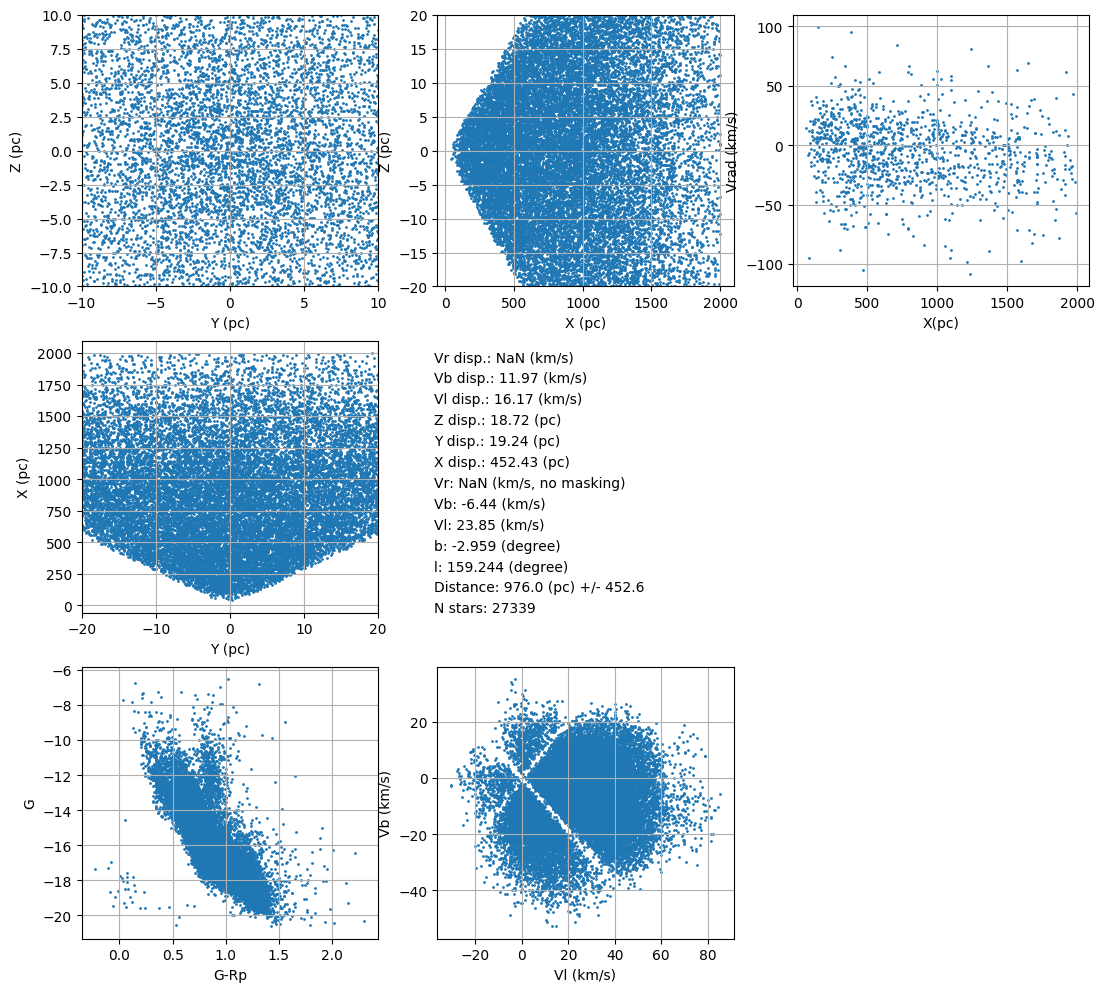

In [6]:
_plot_oc(oc)